## Image segmentation with CamVid

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import fastai
# fastai.torch_core.defaults.device = 'cpu'

In [12]:
insulators = Path('./caravan/')
codes = np.loadtxt(insulators/"codes.txt", dtype=str); codes
label = insulators/"mask"
image = insulators/"image"
get_y = lambda x: label/f"{x.stem}_mask.gif"

## Data

In [14]:
fnames = get_image_files(image)
fnames[:3]

[PosixPath('/home/drones/fastai/caravan/image_sample/1ae8a68a40e4_01.png'),
 PosixPath('/home/drones/fastai/caravan/image_sample/1c5748340af8_13.png'),
 PosixPath('/home/drones/fastai/caravan/image_sample/0ee135a3cccc_08.png')]

In [15]:
lbl_names = get_image_files(label)
lbl_names[:3]

[]

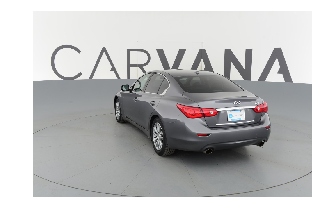

In [16]:
img_f = fnames[2]
img = open_image(img_f)
img.show(figsize=(5,5))

In [17]:
get_y_fn = lambda x: label/f'{x.stem}_mask.gif'

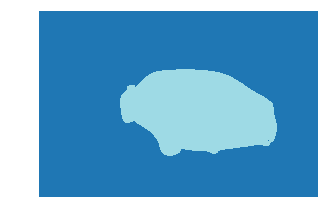

In [19]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [20]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([1280, 1918]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [21]:
codes = np.loadtxt(insulators/'codes.txt', dtype=str); codes

array(['car', 'background'], dtype='<U10')

## Datasets

In [22]:
size = (256,256)#src_size//2
print(size)
bs=2
# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

(256, 256)


In [23]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageList):
    _label_cls = SegLabelListCustom

src = (SegItemListCustom.from_folder(image)
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=codes) )

In [24]:
data = (src.transform(get_transforms(), size=size, tfm_y=True )
        .databunch(bs=bs)
        .normalize(imagenet_stats))

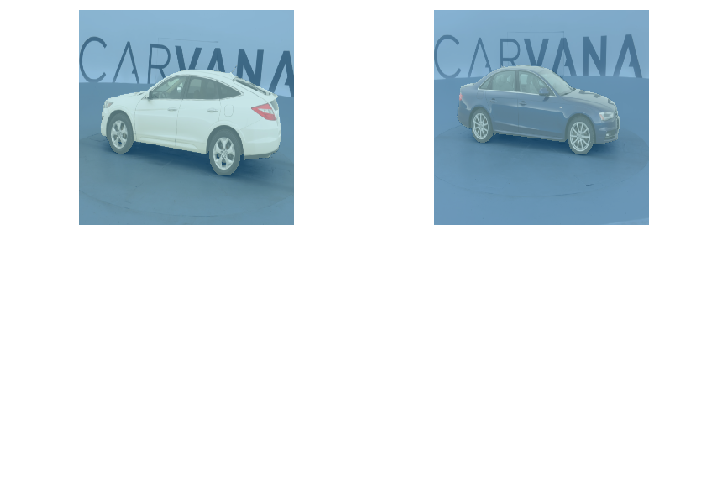

In [25]:
data.show_batch(5, figsize=(10,7))

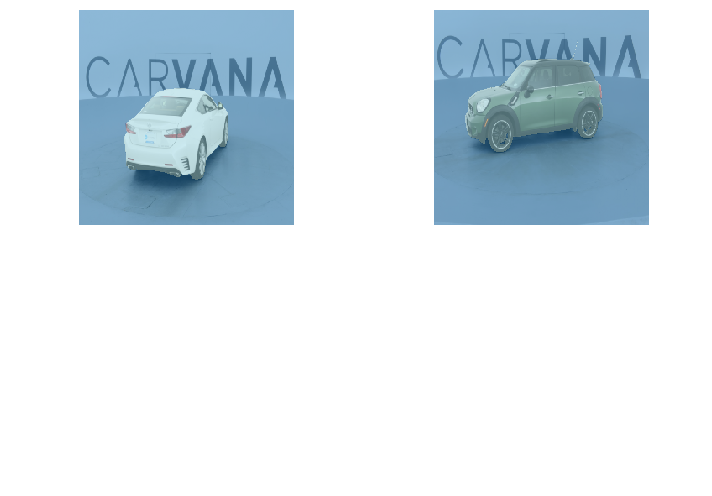

In [26]:
data.show_batch(5, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [27]:
name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
# void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
#     mask = target != void_code
    return (input.argmax(dim=1)==target).float().mean()

{'car': 0, 'background': 1}


In [28]:
metrics=acc_camvid
# metrics=accuracy

In [29]:
wd=1e-2

In [30]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [31]:
data.classes

array(['car', 'background'], dtype='<U10')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


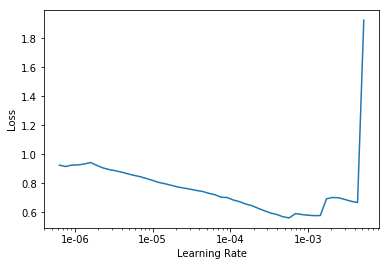

In [32]:
lr_find(learn)
learn.recorder.plot()

In [33]:
lr=1e-5

In [34]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.643272,0.510207,0.817200,00:18
1,0.349405,0.196306,0.929571,00:20
2,0.126866,0.090657,0.966472,00:19
3,0.076501,0.063406,0.976727,00:21
4,0.056605,0.052940,0.980182,00:20
5,0.044556,0.055230,0.980353,00:20
6,0.036997,0.028477,0.988550,00:19
7,0.035021,0.027456,0.989405,00:20
8,0.029342,0.027043,0.989526,00:20
9,0.026490,0.022338,0.991238,00:20


In [35]:
learn.save('stage-1')

In [36]:
learn.load('stage-1');

In [37]:
img = open_image('/home/drones/fastai/caravan/image_png/1ba84b81628e_06.png')

In [38]:
prediction = learn.predict(img)[0]

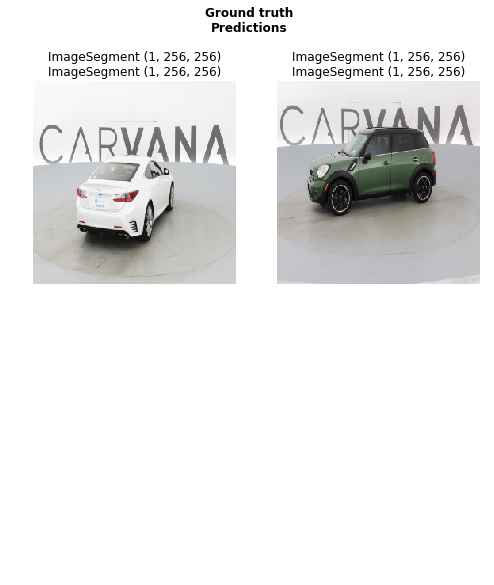

In [42]:
learn.show_results(rows=3, figsize=(8,9))

In [43]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


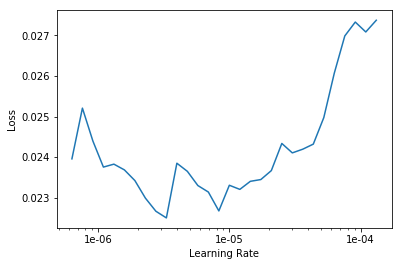

In [44]:
lr_find(learn)
learn.recorder.plot()

In [47]:
lr = 1e-5
lrs = slice(lr/400,lr/4)

In [48]:
learn.fit_one_cycle(100, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.023548,0.020762,0.991760,00:19
1,0.024573,0.021498,0.991538,00:22
2,0.023598,0.023033,0.991042,00:22
3,0.023015,0.021693,0.991481,00:22
4,0.023562,0.021048,0.991747,00:22
5,0.023238,0.021076,0.991705,00:22
6,0.023348,0.022321,0.991244,00:21
7,0.023442,0.023184,0.990998,00:23
8,0.023928,0.021608,0.991524,00:22
9,0.023663,0.021452,0.991596,00:22


In [49]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [50]:
#learn.destroy() # uncomment once 1.0.46 is out

size = (512, 512)

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 5800MB of GPU RAM free


In [51]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [52]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [53]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


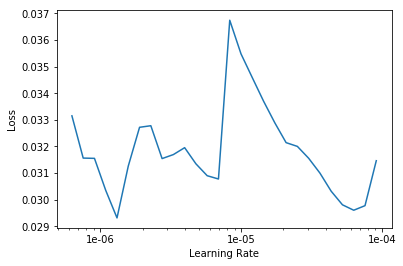

In [54]:
lr_find(learn)
learn.recorder.plot()

In [55]:
lr=1e-6

In [56]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.029783,0.021087,0.992506,00:52
1,0.030005,0.014609,0.994679,00:56
2,0.020021,0.013876,0.994812,00:52
3,0.018712,0.013024,0.995184,00:55
4,0.018502,0.011564,0.995674,00:54
5,0.016181,0.011531,0.995695,00:52
6,0.015771,0.010945,0.995892,00:53
7,0.015761,0.010976,0.995863,00:51
8,0.013676,0.010245,0.996134,00:52
9,0.012829,0.010535,0.996023,00:51


In [57]:
learn.save('stage-1-big')

In [58]:
learn.load('stage-1-big');

In [59]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


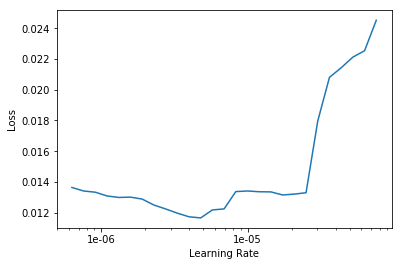

In [60]:
lr_find(learn)
learn.recorder.plot()

In [62]:
lrs = slice(1e-5,lr/10)

In [63]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.013616,0.010601,0.995986,00:54
1,0.013341,0.010287,0.996121,00:55
2,0.013941,0.010091,0.996189,00:55
3,0.012275,0.010016,0.996179,00:56
4,0.011348,0.010265,0.996074,00:56
5,0.012544,0.010334,0.996026,00:56
6,0.012425,0.009916,0.996219,00:58
7,0.012472,0.010190,0.996101,00:59
8,0.010795,0.009787,0.996220,00:55
9,0.012073,0.010135,0.996099,00:56


In [64]:
learn.save('stage-2-big')

In [65]:
learn.load('stage-2-big');

In [67]:
img = open_image('/home/drones/fastai/caravan/image/4df1536de792_11.jpg')

In [68]:
prediction = learn.predict(img)[0]

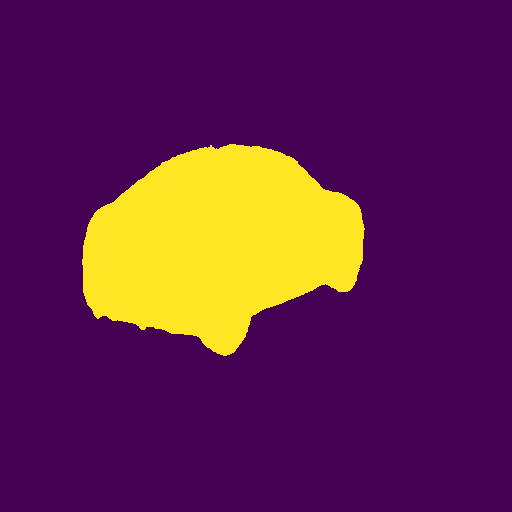

In [69]:
prediction